# Sparse Variational Gaussian Process in Multiclass Classification

In this notebook, sparse variational gaussian process model (VGP) is applied to a multiclass classification problem. VGP is easily scalable to large scale dataset.

## Background

$\qquad$ Consider making inference about a stochastic function $f$ given a likelihood $p(y|f)$ and $N$ observations $y=\{y_1, y_2, \dots, y_N\}^T$ at observation index points $X=\{x_1, x_2, \dots, x_N\}^T$. Place a GP prior on $f$: $p(f) \sim N(f|m(X), K(X, X))$. The joint distribution of data and latent stochastic function is 

$$p(y, f) = \prod_{i=1}^{N}p(y_i|f_i)N(f|m(X), K(X, X)) \tag{1}$$ 

$\qquad$ The main interest is the posterior over the function values given the observations $p(f|y)$. The posterior is intractable when the likelihood $p(y|f)$ is non-Gaussian, which is often the case in classification problems; and the computational complexity is $O(N^3)$ due to the inversion of $K_{X, X}$, which is also intractable for large dataset.

$\qquad$ To reduce the computational complexity, $M << N$ inducing index points $Z=\{z_1, z_2, \dots, z_M\}^T$ and inducing variables $u=f(Z)$ are introduced. Assuming a GP prior on the joint density $p(f, u)$, $$p(f, u) = N\begin{pmatrix} \begin{bmatrix} f \\ u\end{bmatrix}| \begin{bmatrix} m(X) \\ m(Z)\end{bmatrix}, \begin{bmatrix} K(X, X) & K(X, Z) \\ K(Z, X) & K(Z, Z)\end{bmatrix}\end{pmatrix},$$ and a GP prior on $u$ $$p(u) = N(u|m(Z), K(Z, Z)),$$ the conditional of $f$ is $p(f|u) = N(f|\mu, \Sigma)$, where for $i, j = 1, \dots, N$

$$[\mu]_i = m(x_i) + \alpha(x_i)^T(u-m(Z)),   \tag{2}$$

$$[\Sigma]_{ij} = K(x_i, x_j) - \alpha(x_i)^T K(Z, Z)\alpha(x_j), \tag{3}$$
 where $\alpha(x_i) = K(Z, Z)^{-1}K(Z, x_i)$, and the joint density of $y, f, u$ becomes

$$p(y, f, u) = p(f|u; X, Z)p(u; Z)\prod_{i=1}^{N}p(y_i|f_i)$$

$\qquad$ The goal is still finding the posterior of the function values $f$, however, the likelihood $p(y_i|f_i)$ is not Gaussian, so no closed-form solution for the posterior of $f$. Therefore, a variational posterior is used to solve the difficulty. 

$\qquad$ Replacing the posterior $p(u|y)$ by an arbitrary full-rank Gaussian distribution $q(u)$ [Hensman et al. (2013)], then the variational posterior for $y$ and $u$ jointly becomes 

$$q(f, u; X, Z) = p(f|u; X, Z)q(u), \tag{4}$$

$$\mbox{where } q(u) \sim N(\mathbf{m}, \mathbf{S})$$

$\mathbf{m}, \mathbf{S}$ are parameters to be chosen by optimizing an evidence lower bound (ELBO). 

$\qquad$ Since both $p(f|u; X, Z)q(u)$ are Gaussian, the marginal variational posterior of $f$ can be computed analytically

$$q(f|\mathbf{m}, \mathbf{S}; X, Z) = \int p(f|u; X, Z)q(u) du \sim N(\tilde{\mu}, \tilde{\Sigma}) \tag{5}$$

with $[\tilde{\mu}]_i = \mu_{\mathbf{m}, Z}(x_i), [\tilde{\Sigma}]_{ij} = \Sigma_{\mathbf{S}, Z}(x_i, x_j)$, and

$$\mu_{m, Z}(x_i) = m(x_i)+\alpha(x_i)^T(\mathbf{m}-m(Z)) \tag{6}$$
$$\Sigma_{S, Z}(x_i, x_j) = K(x_i, x_j) - \alpha(x_i)^T[K(Z, Z) - \mathbf{S}]\alpha(x_j) \tag{7}$$

$\qquad$ The variation parameters $Z, \mathbf{m}, \mathbf{S}$ in $q(f|\mathbf{m}, \mathbf{S}; X, Z)$ are determined by maximizing the lower bound 

$$L = \sum_{i=1}^N \mathbb{E}_{q(f_i|\mathbf{m}, \mathbf{S}; X, Z)}[logp(y_i|f_i)] - KL[q(u)|| p(u)], \tag{8}$$

where the expected log-likelihood can be computed with Gauss–Hermite quadrature.

$\qquad$ The variational posterior is given as $q(f)$ in (5). To make predictions for a set of test index points $X^*$, the new latent function values $f^*$ is approximated by

\begin{equation}\begin{array}{rcl}p(f^*|y) &=& \int p(f^*|f, u)p(f, u|y) df du\\ &\approx& \int p(f^*|f, u)p(f|u)q(u)df du \\ &=& \int p(f^*|u)q(u) du \\ &=& q(f^*)\end{array}\end{equation}

where the last line is following (5), (6) and (7) by replacing $x_i$ by $x_i^*$.

$\qquad$ With the variational posterior in (5), the predictive mean and variance of $y^*$ are computed as  

$$\hat{y}^* = \mathbb{E}(y^*) = \int\int y^* p(y^*|f^*)q(f^*) df^* dy^* \tag{9}$$
$$\hat{\mathbb{V}}(y^*) = \int\int y^{*2} p(y^*|f^*)q(f^*) df^* dy^* \tag{10}$$

## References

[1]: Titsias, M. "Variational Model Selection for Sparse Gaussian Process Regression", 2009. http://proceedings.mlr.press/v5/titsias09a/titsias09a.pdf 

[2]: Hensman, J., Lawrence, N. "Gaussian Processes for Big Data", 2013. https://arxiv.org/abs/1309.6835

[3]: Salimbeni, H. and Deisenroth, M. "Doubly stochastic variational inference for deep Gaussian processes." Advances in Neural Information Processing Systems. 2017. https://arxiv.org/pdf/1705.08933.pdf

## Imports

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.cluster.vq import kmeans2

tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

dtype = np.float64

## Load Glass Data

A standard imbalanced machine learning dataset referred to as the “Glass Identification” dataset, or simply “glass”.

The dataset describes the chemical properties of glass and involves classifying samples of glass using their chemical properties as one of six classes. The dataset was credited to Vina Spiehler in 1987.

In [100]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/glass.csv

--2020-11-08 09:08:57--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/glass.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.192.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11154 (11K) [text/plain]
Saving to: 'glass.csv.1'

100%[======================================>] 11,154      --.-K/s   in 0.001s  

2020-11-08 09:08:57 (11.2 MB/s) - 'glass.csv.1' saved [11154/11154]



In [102]:
data = pd.read_csv('glass.csv', header=None)
data = data.values
X = data[:,0:9].astype(dtype)
Y = data[:,9]

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
encoded_Y = encoded_Y.astype(dtype)
num_outputs = 6

X_train, X_test, y_train, y_test = train_test_split(X, encoded_Y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, encoded_Y.shape)

(171, 9) (43, 9) (214,)


## Defining Trainable Variables in VGP

* Using kmeans to initialize 30 representative `inducing_index_points` $Z$ and make them learnable variable

In [89]:
num_inducing_points_ = 30
inducing_index_points_init = kmeans2(X_train, num_inducing_points_, minit="points")[0] #50, 60
inducing_index_points = tf.Variable(inducing_index_points_init, dtype=dtype, name='inducing_index_points')

* Initializing RBF kernel and kernel parameters, which are `amplitude` and `length_scale` (the same length scale is used for all $X$ columns)
* Initializing the variational mean and covariance $\mathbf{m}, \mathbf{S}$ in $q(u)$

In [90]:
amplitude = tfp.util.TransformedVariable(
    1., tfb.Softplus(), dtype=dtype, name='amplitude')
length_scale = tfp.util.TransformedVariable(
    1., tfb.Softplus(), dtype=dtype, name='length_scale')
kernel = tfk.ExponentiatedQuadratic(amplitude=amplitude, length_scale=length_scale)

observation_noise_variance = tfp.util.TransformedVariable(1., tfb.Softplus(), dtype=dtype, name='observation_noise_variance')

variational_inducing_observations_loc = tf.Variable(np.zeros([num_outputs, num_inducing_points_], dtype=dtype), name='variational_inducing_observations_loc')

Ku = kernel.matrix(inducing_index_points, inducing_index_points)
variational_inducing_observations_scale_init = np.linalg.cholesky(Ku + np.eye(num_inducing_points_)*1e-6)
variational_inducing_observations_scale = tf.Variable(np.tile(variational_inducing_observations_scale_init[None, :, :], [num_outputs, 1, 1]), 
                                                      name='variational_inducing_observations_scale')

* Defining log probability. For multiclass classification, Categorical distribution is used. The `observations` is a flat array of batch size; since the expected log likelihood in VGP is approximated by Gauss–Hermite quadrature, the input logits is reshaped to (`quadrature_size, batch_size, num_outputs`) to adapt to the `sparse_softmax_cross_entropy_with_logits` in `log_prob`



In [91]:
def log_prob(observations, f):
    #f is (6, 20, 64)
    berns = tfd.Independent(tfd.Categorical(logits=tf.transpose(f, perm=[1,2,0])), 1) #(20, 64, 6), n_quadrature, bs, n_outputs
    return berns.log_prob(observations) #sparse_softmax_cross_entropy_with_logits: have logits of shape [batch_size, num_classes] and have labels of shape [batch_size]

## Constructing Model and Training

In [92]:
vgp = tfd.VariationalGaussianProcess(
    kernel,
    index_points=X_test,
    inducing_index_points=inducing_index_points,
    variational_inducing_observations_loc=variational_inducing_observations_loc, #TensorShape([6, 30])
    variational_inducing_observations_scale=variational_inducing_observations_scale, #TensorShape([6, 30, 30])
    observation_noise_variance=observation_noise_variance)

In [93]:
batch_size = 64

optimizer = tf.optimizers.Adam(learning_rate=.01)

@tf.function
def optimize(x_train_batch, y_train_batch):
    with tf.GradientTape() as tape:
        # Create the loss function we want to optimize.
        recon = vgp.surrogate_posterior_expected_log_likelihood(
          observations=y_train_batch,
          observation_index_points=x_train_batch,
          log_likelihood_fn=log_prob,
          quadrature_size=20)

        elbo = -tf.reduce_sum(recon) + tf.reduce_sum(vgp.surrogate_posterior_kl_divergence_prior())

    grads = tape.gradient(elbo, vgp.trainable_variables)
    optimizer.apply_gradients(zip(grads, vgp.trainable_variables))
    return elbo

## Training by Batch

In [94]:
num_iters = 1200
num_logs = 10
num_training_points_ = X_train.shape[0]

for i in range(num_iters):
    batch_idxs = np.random.randint(num_training_points_, size=[batch_size])
    x_train_batch = X_train[batch_idxs, ...]
    y_train_batch = y_train[batch_idxs]
    loss = optimize(x_train_batch, y_train_batch)

    if i % (num_iters / num_logs) == 0 or i + 1 == num_iters:
        print(i, loss.numpy())


0 114.67260603059552
120 67.871934322895
240 60.0149377742081
360 56.29566984959375
480 53.7197290981309
600 51.48258717207506
720 52.6730473693974
840 44.445047997931475
960 50.50109738207267
1080 44.75255389124902
1199 51.55517736426542


## Computing the Predictive Mean and Variance

To compute the predictive mean and variance for a set of new $X^*$, the `predict_mean_and_var` from gpflow is used to compute (9) and (10). 

In [95]:
from gpflow.likelihoods.multiclass import Softmax

Fmu = tf.cast(tf.transpose(vgp.mean()), tf.float32) #TensorShape([6, 43])
Fvar = tf.cast(tf.transpose(vgp.variance()), tf.float32)##TensorShape([6, 43])

S = Softmax(num_outputs)
m, v = S.predict_mean_and_var(Fmu, Fvar) #shape=(43, 6)

## Results and Plots

In [96]:
acc =np.mean(np.argmax(m, 1).astype(int) == y_test.astype(int))
print("Multiclass classification accuracy for {} is {}".format(num_outputs, acc))

Multiclass classification accuracy for 6 is 0.7209302325581395


In [97]:
indices = np.argmax(m, 1)
v_ = tf.reduce_sum(tf.one_hot(indices, 6)*v, 1)
print("Multiclass classification variances for {} is {}".format(num_outputs, v_))

Multiclass classification variances for 6 is [0.23027779 0.21305028 0.23469782 0.2065194  0.23566929 0.18067268
 0.21430728 0.2347648  0.2097274  0.21258086 0.2179921  0.21743922
 0.2189273  0.22974259 0.22108854 0.20057674 0.1710678  0.21648297
 0.19312762 0.18159598 0.18870537 0.22279613 0.2087079  0.2288218
 0.19952135 0.21122998 0.21671966 0.22578193 0.2281411  0.24098359
 0.17000449 0.2195439  0.20093569 0.20745346 0.19372132 0.24052121
 0.15541928 0.22103915 0.19316027 0.20382655 0.16869901 0.22654828
 0.19985217]


In [98]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
X_test_pca = pca.fit_transform(X_test)
y_preds = np.argmax(m, 1).astype(int)
y_sd = (v_)**0.5

Each dot is the predicted class for each $x_i^*$, and the error bar is one sd of $y_i^*$. If the a dot and a cross overlap, this is a correct prediction.

Text(0.5, 0, 'X_test_pca')

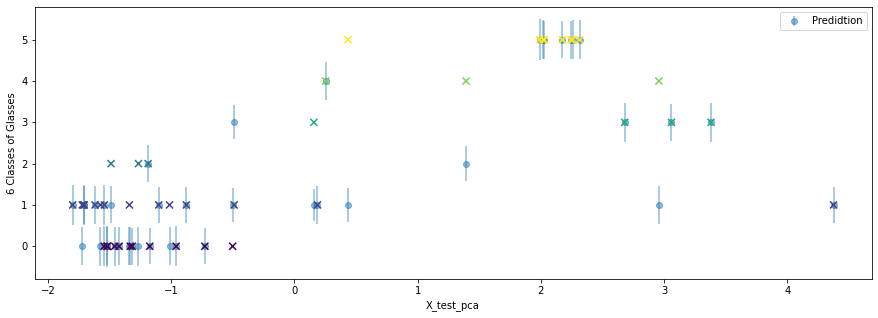

In [99]:
plt.figure(figsize=(15, 5))
plt.scatter(X_test_pca, y_test,
            marker='x', s=50, c=y_test, zorder=10)

plt.errorbar(X_test_pca, y_preds, yerr=y_sd, fmt='o', capthick=1, label='Predidtion', alpha=0.5)
plt.legend(loc='upper right')
plt.ylabel('6 Classes of Glasses')
plt.xlabel('X_test_pca')